In [18]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Stock price analysis").getOrCreate()

In [19]:
file_path = 'weekly_IBM.csv'
df = spark.read.csv(file_path, header = True, inferSchema = True)

In [20]:
df.show()

+----------+------+--------+-------+------+--------+
| timestamp|  open|    high|    low| close|  volume|
+----------+------+--------+-------+------+--------+
|2024-01-05|162.83|  163.29| 158.67|159.16|14822074|
|2023-12-29|162.23|  164.18| 162.05|163.55| 9376537|
|2023-12-22|162.23|  163.33| 159.53|162.14|17686398|
|2023-12-15|162.68|  166.34|160.149|162.23|33504550|
|2023-12-08|160.29|  162.79| 159.97|161.96|21918957|
|2023-12-01|154.99|  160.59| 154.75|160.55|21900644|
|2023-11-24|152.51| 155.705| 152.35|155.18|11362696|
|2023-11-17|148.46|   153.5| 147.35|152.89|19547595|
|2023-11-10|147.89|  149.68| 145.28|149.02|18357944|
|2023-11-03|143.19| 148.445| 142.58| 147.9|22959464|
|2023-10-27|136.63|   144.7| 135.87|142.52|30227448|
|2023-10-20|139.28|  140.62| 136.31|137.16|21044049|
|2023-10-13| 142.3| 143.415| 138.27|138.46|16386334|
|2023-10-06|140.04|  142.94| 139.86|142.03|15932918|
|2023-09-29|146.57|  147.43| 139.61| 140.3|23445425|
|2023-09-22|145.77|151.9299| 144.66|146.91|235

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

In [27]:
w = Window.partitionBy().orderBy("timestamp")

In [29]:
# Feature Engineering
# 1. Create a lagged column for the 'close' price (i.e., previous day's close)
df = df.withColumn("lag_close_1", F.lag(df.close).over(w))

# 2. Calculate daily return - how much did the price change in percentage from opening to closing
df = df.withColumn("daily_return", (df.close - df.open) / df.open)

# 3. Calculate intra-day volatility - difference between the highest and lowest prices of the day
df = df.withColumn("intra_day_volatility", df.high - df.low)

# 4. Calculate daily volatility - change in closing price from the previous day
df = df.withColumn("daily_volatility", df.close - df.lag_close_1)

# 5. Calculate a 7-day moving average for the closing prices
df = df.withColumn("7_day_avg_close", F.avg(df.close).over(w.rowsBetween(-6, 0)))


# Drop any rows with NA values (which might have been introduced due to lagging operations)
df = df.dropna()


In [31]:
df.show()

+----------+------+------+------+------+--------+-----------+--------------------+--------------------+-------------------+------------------+
| timestamp|  open|  high|   low| close|  volume|lag_close_1|        daily_return|intra_day_volatility|   daily_volatility|   7_day_avg_close|
+----------+------+------+------+------+--------+-----------+--------------------+--------------------+-------------------+------------------+
|1999-11-19|  96.0|105.12| 92.62|103.94|61550800|      95.87| 0.08270833333333331|                12.5|  8.069999999999993|            99.905|
|1999-11-26| 105.5|109.87|101.81| 105.0|37165600|     103.94|-0.00473933649289...|   8.060000000000002| 1.0600000000000023|101.60333333333334|
|1999-12-03|104.94|112.87|102.12|111.87|37670000|      105.0| 0.06603773584905667|               10.75| 6.8700000000000045|            104.17|
|1999-12-10| 113.0|122.12|107.56| 109.0|58626000|     111.87|-0.03539823008849...|  14.560000000000002|-2.8700000000000045|105.13600000000001|

In [32]:
# Assemble the features into a single vector for MLlib consumption
feature_columns = ["open", "high", "low", "close", "volume", "daily_return", 
                   "intra_day_volatility", "daily_volatility", "7_day_avg_close", 
                  ]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

In [33]:
df_assembled.show()

+----------+------+------+------+------+--------+-----------+--------------------+--------------------+-------------------+------------------+--------------------+
| timestamp|  open|  high|   low| close|  volume|lag_close_1|        daily_return|intra_day_volatility|   daily_volatility|   7_day_avg_close|            features|
+----------+------+------+------+------+--------+-----------+--------------------+--------------------+-------------------+------------------+--------------------+
|1999-11-19|  96.0|105.12| 92.62|103.94|61550800|      95.87| 0.08270833333333331|                12.5|  8.069999999999993|            99.905|[96.0,105.12,92.6...|
|1999-11-26| 105.5|109.87|101.81| 105.0|37165600|     103.94|-0.00473933649289...|   8.060000000000002| 1.0600000000000023|101.60333333333334|[105.5,109.87,101...|
|1999-12-03|104.94|112.87|102.12|111.87|37670000|      105.0| 0.06603773584905667|               10.75| 6.8700000000000045|            104.17|[104.94,112.87,10...|
|1999-12-10| 113

Root Mean Squared Error (RMSE) on test data = 1.8222302811247466
MAE: 1.4367026263458
R2: 0.9711549375559034


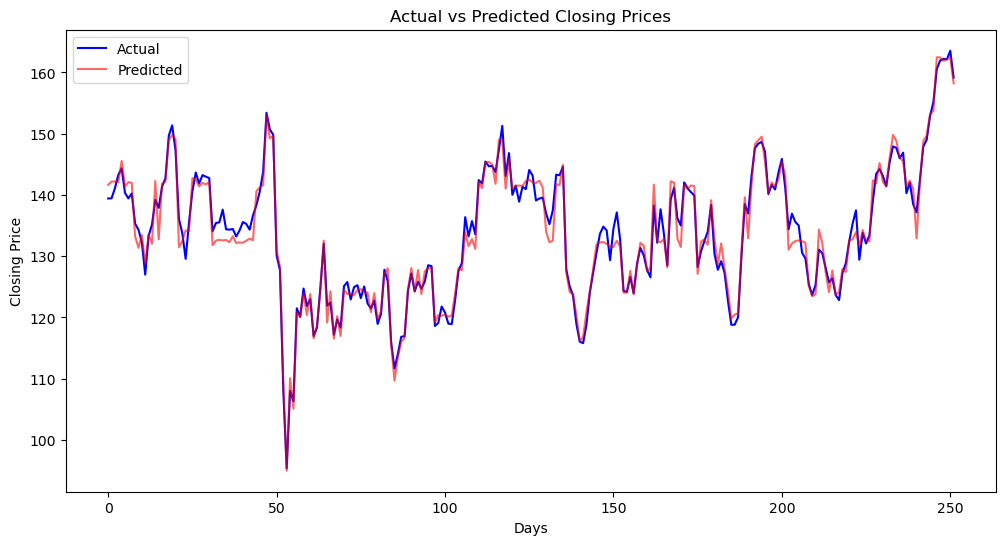

In [36]:
# Split the data into a training set and a test set. 
# Here, we're using a time-based split - 80% for training and 20% for testing
train_count = int(df_assembled.count() * 0.8)
train_data = df_assembled.orderBy("timestamp").limit(train_count)
test_data = df_assembled.subtract(train_data)

# Model Training
# Gradient Boosted Trees are chosen due to their robustness and ability to model non-linear patterns
gbt = GBTRegressor(labelCol="close", featuresCol="features", maxIter=50)
model = gbt.fit(train_data)
predictions = model.transform(test_data)

# Model Evaluation
# Compute the RMSE (Root Mean Squared Error) for the predictions
evaluator_rmse = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

# Compute other metrics: Mean Absolute Error (MAE) and R-squared (R2)
for metric in ["mae", "r2"]:
    evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName=metric)
    value = evaluator.evaluate(predictions)
    print(f"{metric.upper()}: {value}")

# Visualization
# Plot the actual vs predicted values for adjusted closing prices
preds = predictions.select("close", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["close"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Terminate the Spark session
#spark.stop()

In [37]:
spark.stop()